# CAS Assignment 3 

Imports, and setting up image saving

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from random import choice
from random import uniform
from numpy.random import randint
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

	

Pull the dataset and plot some sample images

Train: X=(2500, 28, 28), y=(2500,)
Test: X=(1000, 28, 28), y=(1000,)


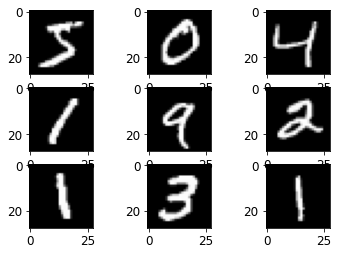

In [2]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# Pull only a subset of images 
# TODO: Balance the dataset with equal examples of each image 
trainX = trainX[:2500]
trainY = trainY[:2500]
testX = testX[:1000]
testY = testY[:1000]
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Using CNN Example from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

Preprocess the dataset, reshape the images to a single color channel 

and "one hot" encode the y_lablels
i.e. the label '3' -> [0,0,0,1,0,0,0,0,0,0] 

In [3]:
# Preprocess train and test dataset
def PreProcess(trainX, trainY, testX, testY, ds="MNIST"):
    #convert single color channel
    if ds=="MNIST":
        trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
        testX = testX.reshape((testX.shape[0], 28, 28, 1))

    #one hot encode labels
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

Normalize pixel values, so high/low pixel values are not weighted to highly by the network

In [4]:
# scale pixels
def PrepPixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [5]:
trainX, trainY, testX, testY = PreProcess(trainX, trainY, testX, testY)
	# prepare pixel data
trainX, testX = PrepPixels(trainX, testX)

Finally the network
we've got a convolutional layer -> max_pooling -> dense layer

In [6]:
def CNN_MNIST(f1, k, a1, a2, op):
	model = Sequential()
	model.add(Conv2D(filters=f1, kernel_size=(k, k), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation=a2, kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))

	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	es = EarlyStopping(monitor="val_accuracy", patience = 7)
	model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10, batch_size = 32, verbose=0)

	return model

GA Code, based on https://github.com/KrishnaManmayi/Hyper-Parameter-Optimization-of-CNN-using-genetic-algorithm/blob/main/Optimization_using_genetic_algorithm_Cifar10_using_CNN.ipynb

In [7]:
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [8]:
def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population

In [9]:
def initialization():  
  parameters = {}
  f1 = choice([32, 64])
  parameters["f1"] = f1
  f2 = choice([64, 128])
  parameters["f2"] = f2
  f3 = choice([128, 256, 512])
  parameters["f3"] = f3
  k = choice([3,5])
  parameters["k"] = k
  a1 = choice(["relu", "selu", "elu"])
  parameters["a1"] = a1
  a2 = choice(["relu", "selu", "elu"])
  parameters["a2"] = a2
  d1 = round(uniform(0.1, 0.5), 1)
  parameters["d1"] = d1
  d2 = round(uniform(0.1, 0.5), 1)
  parameters["d2"] = d2
  op = choice(["adamax", "adadelta", "adam", "adagrad"])
  parameters["op"] = op
  ep = randint(50, 70)
  parameters["ep"] = ep
  return parameters

In [10]:
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child1["f2"] = choice([parent1["f2"], parent2["f2"]])
  child1["f3"] = choice([parent1["f3"], parent2["f3"]])

  child2["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f2"] = choice([parent1["f2"], parent2["f2"]])
  child2["f3"] = choice([parent1["f3"], parent2["f3"]])

  child1["k"] = choice([parent1["k"], parent2["k"]])
  child2["k"] = choice([parent1["k"], parent2["k"]])

  child1["a1"] = parent1["a2"]
  child2["a1"] = parent2["a2"]

  child1["a2"] = parent2["a1"]
  child2["a2"] = parent1["a1"]

  child1["d1"] = parent1["d1"]
  child2["d1"] = parent2["d1"]

  child1["d2"] = parent2["d2"]
  child2["d2"] = parent1["d2"]

  child1["op"] = parent2["op"]
  child2["op"] = parent1["op"]

  child1["ep"] = parent1["ep"]
  child2["ep"] = parent2["ep"]
  return [child1, child2]

In [11]:
def mutation(chromosome):
  flag = randint(0,40)
  if flag <= 20:
    chromosome["ep"] += randint(0, 10)
  return chromosome

In [12]:
# Fitness evaluation metric: Classification Accuracy 
def fitness_evaluation(model, test_images, test_labels):
  metrics = model.evaluate(test_images, test_labels)
  return metrics[1]

In [13]:
generations = 3
threshold = .98
num_pop = 10

population = generate_population(num_pop)

for generation in range(generations):

    population_fitness = []
    for chromosome in population:
        f1 = chromosome["f1"]
        f2 = chromosome["f2"]
        f3 = chromosome["f3"]
        k = chromosome["k"]
        a1 = chromosome["a1"]
        a2 = chromosome["a2"]
        d1 = chromosome["d1"]
        d2 = chromosome["d2"]
        op = chromosome["op"]
        ep = chromosome["ep"]

        try:
            model = CNN_MNIST(f1, k, a1, a2, op)
      
            #history = model.fit(trainX, trainY, epochs=1, batch_size=32, validation_data=(testX, testY), verbose=1)
            acc = fitness_evaluation(model, testX, testY)
            print("Parameters: ", chromosome)
            print("Accuracy: ", round(acc, 3))
        except Exception as e:
            acc = 0
            print("Parameters: ", chromosome)
            print("Invalid parameters - Build fail")
            print(e)

        population_fitness.append(acc)
    parents_ind = selection(population_fitness)
    parent1 = population[parents_ind[0]]
    parent2 = population[parents_ind[1]]

    children = crossover(parent1, parent2)
    child1 = mutation(children[0])
    child2 = mutation(children[1])

    population.append(child1)
    population.append(child2)

    print("Generation ", generation+1, " Outcome: ")
    if max(population_fitness) >= threshold:
        print("Obtained desired accuracy: ", max(population_fitness))
        break
    else:
        print("Maximum accuracy in generation {} : {}".format(
            generation+1, max(population_fitness)))

    first_min = min(population_fitness)
    first_min_ind = population_fitness.index(first_min)
    population.remove(population[first_min_ind])
    second_min = min(population_fitness)
    second_min_ind = population_fitness.index(second_min)
    population.remove(population[second_min_ind])


32/32 [==============================] - 1s 28ms/step - loss: 0.2096 - accuracy: 0.9400
Parameters:  {'f1': 32, 'f2': 64, 'f3': 256, 'k': 3, 'a1': 'selu', 'a2': 'relu', 'd1': 0.5, 'd2': 0.3, 'op': 'adamax', 'ep': 56}
Accuracy:  0.94
32/32 [==============================] - 1s 28ms/step - loss: 0.1964 - accuracy: 0.9430
Parameters:  {'f1': 64, 'f2': 128, 'f3': 128, 'k': 5, 'a1': 'elu', 'a2': 'relu', 'd1': 0.3, 'd2': 0.3, 'op': 'adadelta', 'ep': 69}
Accuracy:  0.943


KeyboardInterrupt: 

In [ ]:
def CreateParamGrid_MNIST():
    f1 = [32, 64]
    k = [3,5]
    a1 = ["relu", "selu", "elu"]
    a2 = ["relu", "selu", "elu"]
    op = ["adamax", "adadelta", "adam", "adagrad"]
    
    return dict(f1 = f1,  k = k, a1 = a1, a2 = a2, op = op)

In [ ]:
num_threads = 1 # -1 for as many as possible

model = KerasClassifier(build_fn=CNN_MNIST, verbose=0)
param_grid = CreateParamGrid_MNIST()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=num_threads, cv=3)
grid_result = grid.fit(trainX, trainY)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

setup CIFAR10 

Based on the network n https://github.com/KrishnaManmayi/Hyper-Parameter-Optimization-of-CNN-using-genetic-algorithm/blob/main/Optimization_using_genetic_algorithm_Cifar10_using_CNN.ipynb

In [ ]:
def CNN_CIFAR10( f1, f2, f3, k, a1, a2, d1, d2, op, ep):
  model = Sequential()
  model.add(Conv2D(filters = f1, kernel_size = (k, k), activation = a1, input_shape = (32,32,3)))
  model.add(Conv2D(filters = f1, kernel_size = (k, k), activation = a1))
  model.add(MaxPooling2D(2,2))
  model.add(Conv2D(filters = f2, kernel_size = (k, k), activation = a2))
  model.add(Conv2D(filters = f2, kernel_size = (k, k), activation = a2))
  model.add(MaxPooling2D(2,2))
  model.add(Flatten())
  model.add(Dropout(rate = d1))
  model.add(Dense(units = f3, activation = a2))
  model.add(Dropout(rate = d2))
  model.add(Dense(10, activation= "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = op, metrics = ["accuracy"])
  es = EarlyStopping(monitor="val_accuracy", patience = 7)
  model.fit(trainX, trainY, validation_data=(testX,testY), epochs=ep, batch_size = 400, callbacks = [es], verbose=1)

  return model

In [ ]:
from tensorflow.keras import datasets
(trainX, trainY), (testX, testY) = datasets.cifar10.load_data()
trainX = trainX[:3000]
trainY = trainY[:3000]
testX = testX[:6000]
testY = testY[:6000]
trainX, trainY, testX, testY = PreProcess(trainX, trainY, testX, testY, "CIFAR10")
	# prepare pixel data
trainX, testX = PrepPixels(trainX, testX)

In [ ]:
generations = 3
threshold = 90
num_pop = 10

population = generate_population(num_pop)

for generation in range(generations):

    population_fitness = []
    for chromosome in population:
        f1 = chromosome["f1"]
        f2 = chromosome["f2"]
        f3 = chromosome["f3"]
        k = chromosome["k"]
        a1 = chromosome["a1"]
        a2 = chromosome["a2"]
        d1 = chromosome["d1"]
        d2 = chromosome["d2"]
        op = chromosome["op"]
        ep = chromosome["ep"]

        try:
            model = CNN_CIFAR10(f1, f2, f3, k, a1, a2, d1, d2, op, 100)
            
            acc = fitness_evaluation(model, testX, testY)
            print("Parameters: ", chromosome)
            print("Accuracy: ", round(acc, 3))
        except Exception as e:
            acc = 0
            print("Parameters: ", chromosome)
            print("Invalid parameters - Build fail")
            print(e)

        population_fitness.append(acc)
    parents_ind = selection(population_fitness)
    parent1 = population[parents_ind[0]]
    parent2 = population[parents_ind[1]]

    children = crossover(parent1, parent2)
    child1 = mutation(children[0])
    child2 = mutation(children[1])

    population.append(child1)
    population.append(child2)

    print("Generation ", generation+1, " Outcome: ")
    if max(population_fitness) >= threshold:
        print("Obtained desired accuracy: ", max(population_fitness))
        break
    else:
        print("Maximum accuracy in generation {} : {}".format(
            generation+1, max(population_fitness)))

    first_min = min(population_fitness)
    first_min_ind = population_fitness.index(first_min)
    population.remove(population[first_min_ind])
    second_min = min(population_fitness)
    second_min_ind = population_fitness.index(second_min)
    population.remove(population[second_min_ind])

In [ ]:
def CreateParamGrid_CIFAR():
    f1 = [32, 64]
    f2 = [64, 128]
    f3 = [128, 256, 512]
    k = [3,5]
    a1 = ["relu", "selu", "elu"]
    a2 = ["relu", "selu", "elu"]
    d1 = [0.1, 0.5]
    d2 = [0.1, 0.5]
    op = ["adamax", "adadelta", "adam", "adagrad"]
    ep = [50, 70]
    
    return dict(f1 = f1, f2 = f2, f3 = f3, k = k, a1 = a1, a2 = a2, d1 = d1, d2 = d2, op = op, ep = ep)

In [ ]:
num_threads = 1 # -1 for as many as possible

model = KerasClassifier(build_fn=CNN_CIFAR, verbose=0)
param_grid = CreateParamGrid_CIFAR()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=num_threads, cv=3)
grid_result = grid.fit(trainX, trainY)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))